In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import struct
from typing import BinaryIO
from simu_param import Simu_param
from find_halo_in_snapshot import Find_halo_in_snapshot

In [2]:
path_cube = "../data/z_0/rpcdm/snapshot/"
name_file = "fof_boxlen648_n2048_rpcdmw7_cube"
num = 0

In [3]:
file = open(path_cube+name_file+'_' +
            str('{:d}'.format(num).zfill(5))+"", "rb")

In [18]:
class Read_snapshot(Simu_param):

    def __init__(self, cosmo: str, z: float) -> None:
        super().__init__(cosmo, z)

    def read_snapshot(self,
                      file: BinaryIO,
                      ) -> dict[str, np.ndarray[float|int]|int]:
        # number of bytes for the total number of particles
        struct.unpack('<i', file.read(4))
        # total number of particles in the cube c
        N_part_tot = struct.unpack('<i', file.read(4))[0]
        # number of bytes of procid, the identity of the binary file
        struct.unpack('<i', file.read(4))
        # procid, the identity of the binary file
        struct.unpack('<i', file.read(4))[0]
        # number of bytes of the boundaries for the position
        struct.unpack('<iii', file.read(4*3))
        # boundaries for the position in box=1 unit
        struct.unpack('<'+str(6)+'f', file.read(4*6))
        struct.unpack('<ii', file.read(8))  # number of bytes for the position
        # positions of all particles in the file, it lies between [0,1] (box unit)
        pos_cube = struct.unpack(
            '<'+str(N_part_tot*3)+'f', file.read(4*3*N_part_tot))
        # number of bytes for the velocities
        struct.unpack('<ii', file.read(8))
        # velocities of all particles in the file, in simu unit
        vel_cube = struct.unpack(
            '<'+str(N_part_tot*3)+'f', file.read(4*3*N_part_tot))
        # number of bytes for the identities
        struct.unpack('<ii', file.read(8))
        # identities of all particles in the file, integers between[1,N_tot_simu]
        ide_cube = struct.unpack(
            '<'+str(N_part_tot)+'q', file.read(8*N_part_tot))
        return {"particles_positions": np.reshape(np.array(pos_cube),(N_part_tot, 3)) * self.L_BOX,
                "particles_velocities": np.reshape(np.array(vel_cube),(N_part_tot, 3)) * self.V_REN,
                "particles_identities": np.array(ide_cube, dtype=np.int64),
                "N_particles": N_part_tot,
        }


read_sn = Read_snapshot(cosmo="rpcdm", z=0)
file = open(path_cube+name_file+'_' +
            str('{:d}'.format(num).zfill(5))+"", "rb")
cube_content = read_sn.read_snapshot(file)

In [24]:
# step 0 ideally, you should open the snapshot file once and for all needed halo
# most efficient: do this when only 1 snapshot is needed
# otherwise, loop on halo as it is more complex to do
# step 1 check cdm issue
# step 2 loop on all snapshot files needed
# step 3 check number of 0 => only needed because I don't use append
# step 4 cdm periodicty change
# step 5 select particles in cube
# step 6 check if you find particles in the snapshot file
# step 8 cdm periodicty change again ?
# check periodicty
# halo selection (spherical, but can try something else aswell)
# store mass, radius of halo
# compute other quantities (concentration, sphericity, virial ratio and shift, 
# subhalo mass ratio, MF v0, sparsity)

In [25]:
# take halo_cube from the method check_halo_in_which_cube and take all halos
# with both the three i_x, i_y and i_z ==0. It corresponds to the halos 
# that are only in 1 snapshot file because they are far from their boundaries.
# It should be 99% of all the halos (to check => done, it is 99.9%)
# then for those 99% halos, compute all their num, and sort these halos by their num.
# For each identical num, one can open 1 time the snapshot file, and close it 1 time 
# when all halos with this identical num have been treated. Then one can continue with 
# the next identical num. 
# When one finished to proceed with all identical num, all the 99% halos have been treated.
# Then one can proceed with the remaining 1% of halos, by doing the loop on the remaining 1% halo
# opening and closing the snapshot files for each halo.


In [2]:
path = "../data/z_0/rpcdm/halos_position/halos_position/"
file_name = "../halo_properties/halo_pos.dat"
halo = pd.read_csv(path + file_name)
cdm = halo[["x (Mpc/h)", "y (Mpc/h)", "z (Mpc/h)"]].values
N_FOF_all = halo["halo N_part"].values

# instantiate my object
find_halo = Find_halo_in_snapshot(cosmo="rpcdm", z=0, N_cubes=512, n_dim=3)

# estimate Rvir then Rlim
Rvir = np.power(N_FOF_all * 3/(4 * np.pi *
                find_halo.RHO_VIR_BRIAN_NORMAN), 1/find_halo.n_dim)
factor = 5
Rlim = factor * Rvir

# first characterization of halo
halo_cube = find_halo.check_halo_in_which_cube(cdm=cdm,
                                                Rlim=Rlim)

dim = 1
dim = 2
dim = 3


In [3]:
find_halo.N_cubes_1D

8

In [4]:
type(halo_cube), halo_cube.shape

(numpy.ndarray, (3066884, 7))

In [5]:
halo_cube[:,4:].shape

(3066884, 3)

In [6]:
ind_1_file = np.where((halo_cube[:,4]==0) & (halo_cube[:,5]==0) & (halo_cube[:,6]==0))[0]
len(ind_1_file), len(halo_cube), len(ind_1_file)/len(halo_cube), len(halo_cube) - len(ind_1_file)

(3066355, 3066884, 0.9998275122241337, 529)

In [7]:
find_halo.N_cubes_1D

8

In [14]:
halo_cube_1_file = halo_cube[ind_1_file]
num = halo_cube_1_file[:,1] * find_halo.N_cubes_1D**2
num += halo_cube_1_file[:,2] * find_halo.N_cubes_1D
num += halo_cube_1_file[:,3]
num

array([  0,   0,   7, ..., 448, 448, 448])

In [15]:
print(halo_cube_1_file.shape)
print(num.shape, num.reshape((len(num),1)).shape)
halo_cube_1_file = np.append(halo_cube_1_file, num.reshape((len(num),1)), axis=1)
halo_cube_1_file.shape

(3066355, 7)
(3066355,) (3066355, 1)


(3066355, 8)

In [20]:
num_unique = np.unique(halo_cube_1_file[:,-1])
len(num_unique)
for num_un in num_unique:
    ind_num = (halo_cube_1_file[:,-1] == num_un)
    halo_cube_use = halo_cube_1_file[ind_num]
print(ind_num)
print(halo_cube_use, halo_cube_use.shape)

[False False False ... False False False]
[[ 995895       7       7 ...       0       0     511]
 [ 996107       7       7 ...       0       0     511]
 [ 996113       7       7 ...       0       0     511]
 ...
 [2537320       7       7 ...       0       0     511]
 [2537353       7       7 ...       0       0     511]
 [2537372       7       7 ...       0       0     511]] (6030, 8)


In [10]:
print(num.max())

511


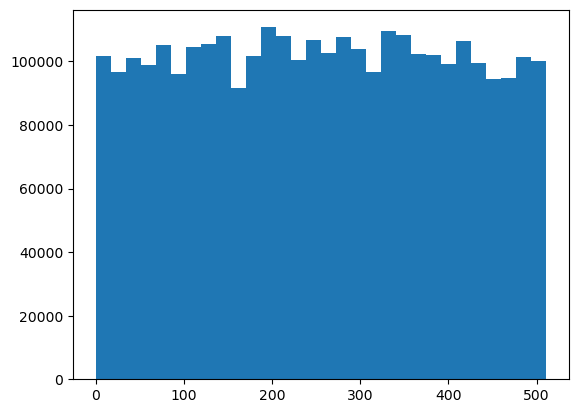

In [9]:
plt.hist(num, 30)
plt.show()

In [19]:
cube_content["N_particles"]

13180312

In [23]:
cube_content["particles_identities"].max()/10**9

8.589934586

In [12]:
cube_content["particles_positions"].shape, cube_content["particles_velocities"].shape

((13180312, 3), (13180312, 3))

In [13]:
cube_content["particles_identities"].shape

(13180312,)

In [15]:
np.mean(cube_content["particles_positions"], axis=0)

array([40.81083565, 43.00759467, 42.60272111])

In [17]:
np.mean(np.abs(cube_content["particles_velocities"]), axis=0)

array([219.74689003, 179.66203264, 120.62877433])